In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [3]:
# import geohash
import os
import logging
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

In [4]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine
import pandas as pd
import time

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [5]:
schema_name = {'cda': 'cuebiq.paas_cda_pe_v3'}
pe_tj_table = f"{schema_name['cda']}.trajectory_uplevelled"

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
def process_daily_data(start_date, end_date, country_code, export_path):
    """
    Process and export daily aggregated data for a specified date range and country.

    Parameters:
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.
    - country_code (str): The country code (e.g., 'CO' for Colombia).
    - export_path (str): The directory where the output files will be saved.
    """

    # Convert the start and end dates to datetime objects
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

    # Iterate through each day in the date range
    current_date = start_date_obj
    while current_date <= end_date_obj:
        event_date = current_date.strftime('%Y%m%d')
        
        csv3_file = f"od_{country_code.lower()}_agg3_daily.csv"
        csv5_file = f"od_{country_code.lower()}_agg5_daily.csv"
        csv3_file_path = os.path.join(export_path, csv3_file)
        csv5_file_path = os.path.join(export_path, csv5_file)

        try:
            # Read data from the SQL table for the specified day and country
            pe_tj_df = sql_engine.read_sql(
                f"""
                SELECT 
                    cuebiq_id,
                    geohash_encode(start_lat, start_lng, 5) AS start_geohash5,
                    geohash_encode(start_lat, start_lng, 3) AS start_geohash3,
                    geohash_encode(end_lat, end_lng, 5) AS end_geohash5,
                    geohash_encode(end_lat, end_lng, 3) AS end_geohash3,
                    DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
                    duration_minutes,
                    length_meters,
                    number_of_points
                FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
                WHERE 
                    event_date = {event_date}
                    AND end_country = '{country_code}' 
                    AND start_country = '{country_code}' 
                """
            )
            logging.info(f"Executing SQL query for date {event_date}")

            # Aggregation 3
            aggregated_df3 = pe_tj_df.groupby(['start_geohash3', 'end_geohash3']).agg({
                'cuebiq_id': 'count',
                'duration_minutes': ['mean', 'median', 'std'],
                'length_meters': ['mean', 'median', 'std'],
                'number_of_points': ['mean', 'median', 'std'],
                'local_date': 'first' 
            }).reset_index()
            aggregated_df3.columns = ['start_geohash3', 'end_geohash3', 'trip_count', 
                                      'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                      'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                      'm_points_no', 'mdn_points_no', 'sd_points_no',
                                     'local_date']

            # Reorder columns
            aggregated_df3 = aggregated_df3[['start_geohash3', 'end_geohash3', 'trip_count', 
                                         'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                        'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                       'm_points_no', 'mdn_points_no', 'sd_points_no',
                                            'local_date']]
            logging.info(f"Exporting aggregated data (geohash3) for date: {event_date}")
            if not os.path.isfile(csv3_file_path):
                aggregated_df3.to_csv(csv3_file_path, index=False)
            else:
                aggregated_df3.to_csv(csv3_file_path, mode='a', header=False, index=False)

            # Aggregation 5
            aggregated_df5 = pe_tj_df.groupby(['start_geohash5', 'end_geohash5']).agg({
                'cuebiq_id': 'count',
                'duration_minutes': ['mean', 'median', 'std'],
                'length_meters': ['mean', 'median', 'std'],
                'number_of_points': ['mean', 'median', 'std'],
                'local_date': 'first' 
            }).reset_index()
            aggregated_df5.columns = ['start_geohash5', 'end_geohash5', 'trip_count', 
                                      'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                      'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                      'm_points_no', 'mdn_points_no', 'sd_points_no',
                                     'local_date']

            # Reorder columns
            aggregated_df5 = aggregated_df5[['start_geohash5', 'end_geohash5', 'trip_count', 
                                         'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                        'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                       'm_points_no', 'mdn_points_no', 'sd_points_no',
                                            'local_date']]
            logging.info(f"Exporting aggregated data (geohash5) for date: {event_date}")
            if not os.path.isfile(csv5_file_path):
                aggregated_df5.to_csv(csv5_file_path, index=False)
            else:
                aggregated_df5.to_csv(csv5_file_path, mode='a', header=False, index=False)

        except Exception as e:
            logging.error(f"Error processing data for date {event_date}: {e}")
        
        # Move to the next day
        current_date += timedelta(days=1)


In [9]:
# Example usage
process_daily_data('2020-09-20', '2020-12-31', 'CO', '/home/jovyan/Data/2020OD/daily/')

2024-08-16 19:04:31,167 - INFO - Executing SQL query for date 20200920
2024-08-16 19:04:31,178 - INFO - Exporting aggregated data (geohash3) for date: 20200920
2024-08-16 19:04:31,208 - INFO - Exporting aggregated data (geohash5) for date: 20200920
2024-08-16 19:04:39,302 - INFO - Executing SQL query for date 20200921
2024-08-16 19:04:39,313 - INFO - Exporting aggregated data (geohash3) for date: 20200921
2024-08-16 19:04:39,337 - INFO - Exporting aggregated data (geohash5) for date: 20200921
2024-08-16 19:04:47,165 - INFO - Executing SQL query for date 20200922
2024-08-16 19:04:47,177 - INFO - Exporting aggregated data (geohash3) for date: 20200922
2024-08-16 19:04:47,201 - INFO - Exporting aggregated data (geohash5) for date: 20200922
2024-08-16 19:04:55,182 - INFO - Executing SQL query for date 20200923
2024-08-16 19:04:55,194 - INFO - Exporting aggregated data (geohash3) for date: 20200923
2024-08-16 19:04:55,218 - INFO - Exporting aggregated data (geohash5) for date: 20200923
2024

KeyboardInterrupt: 

In [ ]:
process_daily_data('2020-01-01', '2020-12-31', 'ID', '/home/jovyan/Data/2020OD/daily/')

In [ ]:
process_daily_data('2020-01-01', '2020-12-31', 'IN', '/home/jovyan/Data/2020OD/daily/')

In [ ]:
process_daily_data('2020-01-01', '2020-12-31', 'MX', '/home/jovyan/Data/2020OD/daily/')

# Fill up missing dates:

In [24]:
from datetime import datetime, timedelta
import os
import logging

def process_daily_data(dates, country_code, export_path):
    """
    Process and export daily aggregated data for a specified list of dates and country.

    Parameters:
    - dates (list): A list of dates in the format 'YYYYMMDD'.
    - country_code (str): The country code (e.g., 'CO' for Colombia).
    - export_path (str): The directory where the output files will be saved.
    """

    for date_str in dates:
        # Convert the date string to a datetime object
        event_date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = event_date_obj.strftime('%Y%m%d')

        csv3_file = f"od_{country_code.lower()}_agg3_daily.csv"
        csv5_file = f"od_{country_code.lower()}_agg5_daily.csv"
        csv3_file_path = os.path.join(export_path, csv3_file)
        csv5_file_path = os.path.join(export_path, csv5_file)

        try:
            # Read data from the SQL table for the specified day and country
            pe_tj_df = sql_engine.read_sql(
                f"""
                SELECT 
                    cuebiq_id,
                    geohash_encode(start_lat, start_lng, 5) AS start_geohash5,
                    geohash_encode(start_lat, start_lng, 3) AS start_geohash3,
                    geohash_encode(end_lat, end_lng, 5) AS end_geohash5,
                    geohash_encode(end_lat, end_lng, 3) AS end_geohash3,
                    DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
                    duration_minutes,
                    length_meters,
                    number_of_points
                FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
                WHERE 
                    event_date = {event_date}
                    AND end_country = '{country_code}' 
                    AND start_country = '{country_code}' 
                """
            )
            logging.info(f"Executing SQL query for date {event_date}")

            # Aggregation 3
            aggregated_df3 = pe_tj_df.groupby(['start_geohash3', 'end_geohash3']).agg({
                'cuebiq_id': 'count',
                'duration_minutes': ['mean', 'median', 'std'],
                'length_meters': ['mean', 'median', 'std'],
                'number_of_points': ['mean', 'median', 'std'],
                'local_date': 'first' 
            }).reset_index()
            aggregated_df3.columns = ['start_geohash3', 'end_geohash3', 'trip_count', 
                                      'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                      'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                      'm_points_no', 'mdn_points_no', 'sd_points_no',
                                     'local_date']

            # Reorder columns
            aggregated_df3 = aggregated_df3[['start_geohash3', 'end_geohash3', 'trip_count', 
                                         'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                        'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                       'm_points_no', 'mdn_points_no', 'sd_points_no',
                                            'local_date']]
            logging.info(f"Exporting aggregated data (geohash3) for date: {event_date}")
            if not os.path.isfile(csv3_file_path):
                aggregated_df3.to_csv(csv3_file_path, index=False)
            else:
                aggregated_df3.to_csv(csv3_file_path, mode='a', header=False, index=False)

            # Aggregation 5
            aggregated_df5 = pe_tj_df.groupby(['start_geohash5', 'end_geohash5']).agg({
                'cuebiq_id': 'count',
                'duration_minutes': ['mean', 'median', 'std'],
                'length_meters': ['mean', 'median', 'std'],
                'number_of_points': ['mean', 'median', 'std'],
                'local_date': 'first' 
            }).reset_index()
            aggregated_df5.columns = ['start_geohash5', 'end_geohash5', 'trip_count', 
                                      'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                      'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                      'm_points_no', 'mdn_points_no', 'sd_points_no',
                                     'local_date']

            # Reorder columns
            aggregated_df5 = aggregated_df5[['start_geohash5', 'end_geohash5', 'trip_count', 
                                         'm_duration_min', 'mdn_duration_min', 'sd_duration_min', 
                                        'm_length_m', 'mdn_length_m', 'sd_length_m', 
                                       'm_points_no', 'mdn_points_no', 'sd_points_no',
                                            'local_date']]
            logging.info(f"Exporting aggregated data (geohash5) for date: {event_date}")
            if not os.path.isfile(csv5_file_path):
                aggregated_df5.to_csv(csv5_file_path, index=False)
            else:
                aggregated_df5.to_csv(csv5_file_path, mode='a', header=False, index=False)

        except Exception as e:
            logging.error(f"Error processing data for date {event_date}: {e}")


In [66]:
# dates = ['20200501', '20200918', '20200919']
dates = ['20200501']
process_daily_data(dates, 'CO', '/home/jovyan/Data/2020OD/daily/')

In [37]:
dates = ['20200501']
process_daily_data(dates, 'IN', '/home/jovyan/Data/2020OD/daily/')

2024-08-12 19:35:54,789 - INFO - Executing SQL query for date 20200501
2024-08-12 19:35:54,800 - INFO - Exporting aggregated data (geohash3) for date: 20200501
2024-08-12 19:35:54,815 - INFO - Exporting aggregated data (geohash5) for date: 20200501


# Only GH3 for CO 2020

In [ ]:
def fetch_and_save_aggregated_data(start_date, end_date, country_code, output_csv):
    """
    Fetches aggregated trajectory data from the SQL database and saves the output to a CSV file.

    Parameters:
    - start_date (int): The start date for filtering data (e.g., 20200701).
    - end_date (int): The end date for filtering data (e.g., 20201231).
    - country_code (str): The country code to filter the data (e.g., 'CO').
    - output_csv (str): The file path where the CSV should be saved.
    """

    query = f"""
    SELECT 
        local_date,
        start_geohash3,
        end_geohash3,
        COUNT(cuebiq_id) AS trip_count,
        ROUND(AVG(duration_minutes), 6) AS m_duration_min,
        ROUND(APPROX_PERCENTILE(duration_minutes, 0.5), 6) AS mdn_duration_min,
        ROUND(STDDEV(duration_minutes), 6) AS sd_duration_min,
        ROUND(AVG(length_meters), 6) AS m_length_m,
        ROUND(APPROX_PERCENTILE(length_meters, 0.5), 6) AS mdn_length_m,
        ROUND(STDDEV(length_meters), 6) AS sd_length_m,
        ROUND(AVG(number_of_points), 6) AS m_points_no,
        ROUND(APPROX_PERCENTILE(number_of_points, 0.5), 6) AS mdn_points_no,
        ROUND(STDDEV(number_of_points), 6) AS sd_points_no
    FROM (
        SELECT 
            cuebiq_id,
            geohash_encode(start_lat, start_lng, 3) AS start_geohash3,
            geohash_encode(end_lat, end_lng, 3) AS end_geohash3,
            DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
            duration_minutes,
            length_meters,
            number_of_points
        FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
        WHERE 
            event_date BETWEEN {start_date} AND {end_date}
            AND end_country = '{country_code}' 
            AND start_country = '{country_code}'
    ) AS subquery
    GROUP BY 
        start_geohash3, end_geohash3, local_date
    """

    # Execute the SQL query and read the result into a DataFrame
    df = sql_engine.read_sql(query)

#     # Save the DataFrame to a CSV file
#     df.to_csv(output_csv, index=False)

#     print(f"Data successfully saved to {output_csv}")

In [ ]:
fetch_and_save_aggregated_data(20200101, 20200131, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_1.csv')

# Check

In [22]:
import io
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [23]:
country_code = 'CO'
# country_code = 'ID'
# country_code = 'IN'
# country_code = 'MX'

file = f'/home/jovyan/Data/2020OD/daily/od_{country_code.lower()}_agg3_daily.csv'
# file = f'/home/jovyan/Data/2020OD/daily/od_{country_code.lower()}_agg5_daily.csv'

df = pd.read_csv(file)
df

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
0,6rf,6rf,5,226.706667,229.100000,213.727843,9811.652889,572.363874,17417.441190,4.400000,5.0,1.341641,2020-01-01
1,6rq,6rm,1,127.316667,127.316667,NaN,17450.350512,17450.350512,NaN,2.000000,2.0,NaN,2020-01-01
2,d0r,d0r,42,127.035714,40.125000,220.738586,5725.666736,732.695530,12152.254708,7.619048,5.5,7.384732,2020-01-01
3,d0r,d22,6,124.819444,69.000000,125.071984,6412.743010,5850.155269,3659.268238,7.333333,8.5,4.366539,2020-01-01
4,d20,d20,192,83.267882,38.333333,156.625051,4172.378778,700.831022,8795.219243,5.510417,4.0,4.145255,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48521,d4q,d4q,1,37.583333,37.583333,NaN,429.963946,429.963946,NaN,6.000000,6.0,NaN,2020-09-29
48522,d65,d3g,5,110.596667,68.333333,110.526098,3334.413966,2213.271715,2777.298064,8.600000,10.0,4.393177,2020-09-29
48523,d65,d65,9,45.003704,25.750000,41.796184,255.845560,248.580419,105.177663,4.111111,5.0,1.269296,2020-09-29
48524,d6h,d6h,34,48.270098,28.291667,46.635740,21499.158324,1337.062459,115782.571502,3.970588,4.0,1.866536,2020-09-29


In [15]:
df[df['local_date'] == '2020-12-29']

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
46810,6rf,6rf,10,32.036667,21.516667,29.532936,777.339018,561.894104,729.368601,5.400000,5.5,2.716207,2020-12-29
46811,d0r,d0r,6,80.875000,73.066667,75.632770,15019.078664,1985.762781,33084.015678,8.000000,5.0,7.042727,2020-12-29
46812,d0r,d20,1,68.450000,68.450000,NaN,59934.948540,59934.948540,NaN,8.000000,8.0,NaN,2020-12-29
46813,d20,d0r,1,630.716667,630.716667,NaN,65507.839579,65507.839579,NaN,42.000000,42.0,NaN,2020-12-29
46814,d20,d20,78,82.314103,41.816667,111.714401,3246.208315,1219.367184,5392.163877,5.448718,4.5,3.417478,2020-12-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46928,d4j,d4j,32,48.317708,12.025000,99.886906,1823.330325,286.387152,3304.478789,4.281250,3.0,2.831099,2020-12-29
46929,d65,d3g,6,181.263889,34.858333,244.521650,8566.428105,5442.765632,9682.102939,49.500000,4.5,100.707001,2020-12-29
46930,d65,d65,14,70.385714,19.308333,128.654358,1886.471176,334.330250,4174.876192,14.000000,4.0,32.722610,2020-12-29
46931,d6h,d6h,39,42.778205,22.883333,54.826869,2128.605609,1310.196038,4451.175755,5.512821,5.0,4.216957,2020-12-29


## Check duplicates

In [24]:
df['start_geohash3'] = df['start_geohash3'].astype(str)
df['end_geohash3'] = df['end_geohash3'].astype(str)

# df['start_geohash5'] = df['start_geohash5'].astype(str)
# df['end_geohash5'] = df['end_geohash5'].astype(str)

# df['local_date'] = df['local_date'].astype(int)
df['trip_count'] = df['trip_count'].astype(int)
df['m_duration_min'] = df['m_duration_min'].astype(float)
df['mdn_duration_min'] = df['mdn_duration_min'].astype(float)
df['sd_duration_min'] = df['sd_duration_min'].astype(float)
df['m_length_m'] = df['m_length_m'].astype(float)
df['mdn_length_m'] = df['mdn_length_m'].astype(float)
df['sd_length_m'] = df['sd_length_m'].astype(float)
df['m_points_no'] = df['m_points_no'].astype(float)
df['mdn_points_no'] = df['mdn_points_no'].astype(float)
df['sd_points_no'] = df['sd_points_no'].astype(float)

# Round float columns to 6 decimal places
float_columns = ['m_duration_min', 'mdn_duration_min', 'sd_duration_min',
                 'm_length_m', 'mdn_length_m', 'sd_length_m',
                 'm_points_no', 'mdn_points_no', 'sd_points_no']

df[float_columns] = df[float_columns].round(6)
df

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
0,6rf,6rf,5,226.706667,229.100000,213.727843,9811.652889,572.363874,17417.441190,4.400000,5.0,1.341641,2020-01-01
1,6rq,6rm,1,127.316667,127.316667,NaN,17450.350512,17450.350512,NaN,2.000000,2.0,NaN,2020-01-01
2,d0r,d0r,42,127.035714,40.125000,220.738586,5725.666736,732.695530,12152.254708,7.619048,5.5,7.384732,2020-01-01
3,d0r,d22,6,124.819444,69.000000,125.071984,6412.743010,5850.155269,3659.268238,7.333333,8.5,4.366539,2020-01-01
4,d20,d20,192,83.267882,38.333333,156.625051,4172.378778,700.831022,8795.219243,5.510417,4.0,4.145255,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48521,d4q,d4q,1,37.583333,37.583333,NaN,429.963946,429.963946,NaN,6.000000,6.0,NaN,2020-09-29
48522,d65,d3g,5,110.596667,68.333333,110.526098,3334.413966,2213.271715,2777.298064,8.600000,10.0,4.393177,2020-09-29
48523,d65,d65,9,45.003704,25.750000,41.796184,255.845560,248.580419,105.177663,4.111111,5.0,1.269296,2020-09-29
48524,d6h,d6h,34,48.270098,28.291667,46.635740,21499.158324,1337.062459,115782.571502,3.970588,4.0,1.866536,2020-09-29


In [13]:
# To check the ones to remove
# original_df = df.copy()

# # Drop duplicates
# df = df.drop_duplicates()

# # Find the rows that were removed
# removed_rows = original_df[~original_df.index.isin(df.index)]
# removed_rows

In [25]:
df = df.drop_duplicates().reset_index(drop= True)
df

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
0,6rf,6rf,5,226.706667,229.100000,213.727843,9811.652889,572.363874,17417.441190,4.400000,5.0,1.341641,2020-01-01
1,6rq,6rm,1,127.316667,127.316667,NaN,17450.350512,17450.350512,NaN,2.000000,2.0,NaN,2020-01-01
2,d0r,d0r,42,127.035714,40.125000,220.738586,5725.666736,732.695530,12152.254708,7.619048,5.5,7.384732,2020-01-01
3,d0r,d22,6,124.819444,69.000000,125.071984,6412.743010,5850.155269,3659.268238,7.333333,8.5,4.366539,2020-01-01
4,d20,d20,192,83.267882,38.333333,156.625051,4172.378778,700.831022,8795.219243,5.510417,4.0,4.145255,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47198,d65,d3g,5,73.373333,43.600000,60.988561,1600.148916,513.986445,1550.017729,3.400000,3.0,1.516575,2020-09-19
47199,d65,d65,8,65.975000,26.533333,123.380703,642.103809,559.809924,706.242594,4.750000,4.5,2.187628,2020-09-19
47200,d6h,d3u,1,199.000000,199.000000,NaN,2058.150829,2058.150829,NaN,3.000000,3.0,NaN,2020-09-19
47201,d6h,d6h,52,93.056731,26.325000,174.635905,2138.107150,1263.786315,2474.397038,4.750000,4.0,4.120132,2020-09-19


In [27]:
df[df['local_date'] == '2020-10-31']

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
39279,6rf,6rf,2,560.966667,560.966667,237.069334,2557.087448,2557.087448,3407.659180,9.500000,9.5,10.606602,2020-10-31
39280,d0r,d0r,3,103.266667,31.200000,144.566121,2496.136425,3157.057936,1872.577822,5.333333,5.0,2.516611,2020-10-31
39281,d0r,d22,1,51.216667,51.216667,NaN,28185.924358,28185.924358,NaN,7.000000,7.0,NaN,2020-10-31
39282,d20,d20,64,73.417969,38.475000,101.688133,3113.424393,708.459260,7043.662920,5.062500,4.0,3.069952,2020-10-31
39283,d21,d21,146,90.186644,31.900000,150.507226,3698.048345,1336.351087,7395.628095,4.986301,4.0,4.740124,2020-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39395,d65,d3g,2,175.325000,175.325000,143.130198,5182.836780,5182.836780,1813.540706,6.000000,6.0,1.414214,2020-10-31
39396,d65,d65,3,44.483333,20.316667,48.272879,254.920242,153.523754,176.637530,2.666667,2.0,1.154701,2020-10-31
39397,d6h,d6h,31,83.954301,25.000000,126.880806,2469.635151,936.458734,4092.178580,5.161290,4.0,3.277161,2020-10-31
39398,d90,d3p,1,11.183333,11.183333,NaN,724.700156,724.700156,NaN,2.000000,2.0,NaN,2020-10-31


## Check missing dates

In [28]:
unique_values_count = df["local_date"].unique()
all_dates = pd.date_range(start='2020-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# all_dates = pd.date_range(start='2019-01-01', end='2019-12-31').strftime('%Y%m%d').astype(int)

all_dates = np.array(all_dates)
missing_dates = np.setdiff1d(all_dates, unique_values_count)

missing_dates

array(['2020-05-01'], dtype=object)

### Check with figure

2024-08-16 19:07:57,792 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-16 19:07:57,809 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-16 19:07:58,187 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-16 19:07:58,202 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


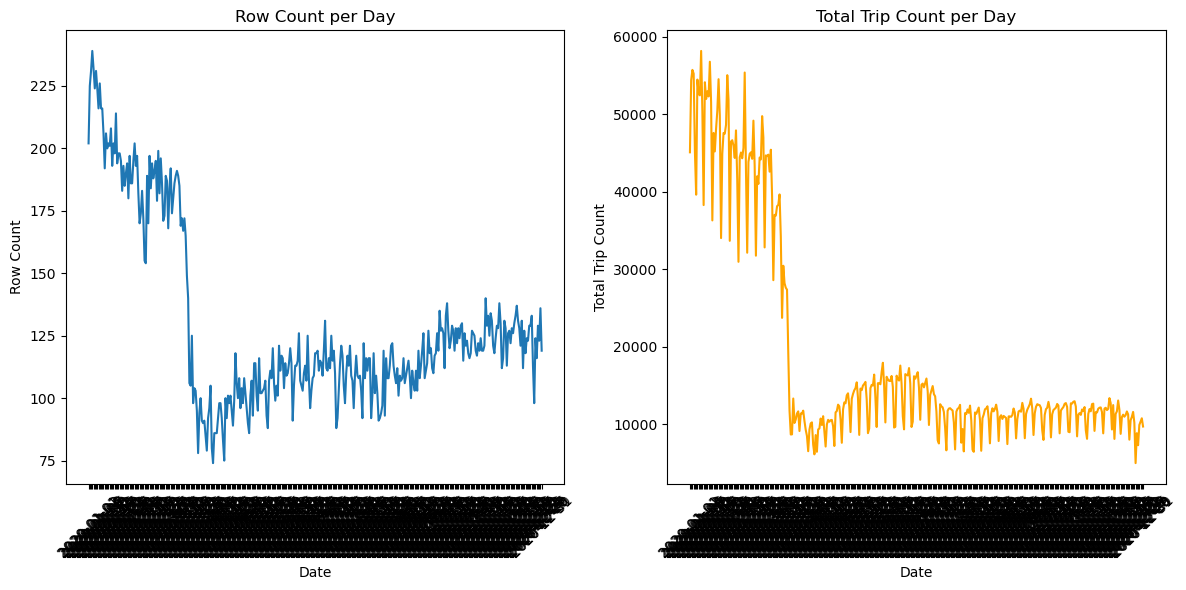

In [29]:
# Group by local_date and calculate the total number of rows and total trip_count
daily_summary = df.groupby('local_date').agg(row_count=('trip_count', 'size'), total_trip_count=('trip_count', 'sum')).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot for row count
plt.subplot(1, 2, 1)
plt.plot(daily_summary['local_date'], daily_summary['row_count'], linestyle='-')
plt.title('Row Count per Day')
plt.xlabel('Date')
plt.ylabel('Row Count')
plt.xticks(rotation=45)

# Plot for total trip count
plt.subplot(1, 2, 2)
plt.plot(daily_summary['local_date'], daily_summary['total_trip_count'], color='orange', linestyle='-')
plt.title('Total Trip Count per Day')
plt.xlabel('Date')
plt.ylabel('Total Trip Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Clean up and Export

In [32]:
df['local_date'] = pd.to_datetime(df['local_date']).dt.strftime('%Y%m%d').astype(int)
filter_df = df[df['trip_count']>9]
filter_df

,start_geohash3,end_geohash3,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_date
2,d0r,d0r,42,127.035714,40.125000,220.738586,5725.666736,732.695530,12152.254708,7.619048,5.5,7.384732,20200101
4,d20,d20,192,83.267882,38.333333,156.625051,4172.378778,700.831022,8795.219243,5.510417,4.0,4.145255,20200101
7,d21,d21,570,89.858070,34.575000,150.820818,4309.254887,1128.231861,15539.096567,5.628070,5.0,3.762536,20200101
14,d22,d22,39,100.856838,45.366667,140.762319,4284.822123,728.537812,10847.946301,5.692308,5.0,4.237389,20200101
16,d23,d23,602,101.263012,38.800000,174.696029,5910.919752,1168.569012,26558.424743,5.387043,4.0,4.123069,20200101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47190,d3k,d3k,325,65.605436,31.066667,98.889295,4188.968682,1272.815005,11108.211434,5.310769,4.0,4.605958,20200919
47192,d3m,d3m,12,83.956944,48.650000,109.695331,2227.463557,1859.897198,2627.217669,3.750000,2.5,2.734460,20200919
47194,d3u,d3u,16,111.862500,54.483333,147.210248,7645.251240,3571.147703,11791.072225,5.125000,4.0,3.263434,20200919
47197,d4j,d4j,14,85.916667,59.208333,78.016860,4473.871845,2099.207287,7106.652174,6.142857,5.0,4.382784,20200919


In [30]:
# Save the combined DataFrame to a new CSV file
com_path = '/home/jovyan/Data/2020OD/daily/combined/'

df.to_csv(com_path + f'od_daily_gh3_{country_code.lower()}_2020_all.csv', index=False)
# df.to_csv(com_path + f'od_daily_gh5_{country_code.lower()}_2020_all.csv', index=False)

In [33]:
folder_path = '/home/jovyan/Data/2020OD/daily/cleaned/'

filter_df.to_csv(folder_path + f'od_daily_gh3_{country_code.lower()}_2020.csv', index=False)
# filter_df.to_csv(folder_path + f'od_daily_gh5_{country_code.lower()}_2020.csv', index=False)

Error handelling. some days missing for 3h, reget here.

In [45]:
event_date = 20200229
country_code = 'MX'
year = 2020

pe_tj_df = sql_engine.read_sql(
    f"""
    SELECT 
        cuebiq_id,
        geohash_encode(start_lat, start_lng, 5) AS start_geohash5,
        geohash_encode(start_lat, start_lng, 3) AS start_geohash3,
        geohash_encode(end_lat, end_lng, 5) AS end_geohash5,
        geohash_encode(end_lat, end_lng, 3) AS end_geohash3,
        EXTRACT(HOUR FROM TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS event_hour,
        DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
        duration_minutes,
        length_meters,
        number_of_points
    FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
    WHERE 
        event_date = {event_date}
        AND end_country = '{country_code}' 
        AND start_country = '{country_code}' 
    """
)
pe_tj_df

,cuebiq_id,start_geohash5,start_geohash3,end_geohash5,end_geohash3,event_hour,local_date,duration_minutes,length_meters,number_of_points
0,3125187230,9etjm,9et,9etjm,9et,20,2020-02-29,4.016667,217.870429,2
1,3125187230,9etjm,9et,9etjm,9et,21,2020-02-29,33.600000,220.866901,3
2,3125173965,9gd1f,9gd,9gd41,9gd,17,2020-02-29,106.583333,6676.005054,7
3,3125056373,9ewkx,9ew,9ewmx,9ew,16,2020-02-29,111.983333,21212.937568,7
4,3124899077,9g3t8,9g3,9g3qn,9g3,22,2020-02-29,35.466667,11939.371345,3
...,...,...,...,...,...,...,...,...,...,...
290022,2830619796,9etjm,9et,9etjm,9et,15,2020-02-29,46.866667,3358.392483,7
290023,1964805448,9scu6,9sc,9scu7,9sc,11,2020-02-29,100.850000,4645.342048,4
290024,1964805448,9scu7,9sc,9scu6,9sc,13,2020-02-29,63.283333,4598.948237,3
290025,1964805448,9scu6,9sc,9scu3,9sc,14,2020-02-29,36.383333,5760.916605,3


In [46]:
pe_tj_df['local_date'] = pd.to_datetime(pe_tj_df['local_date'], format='%Y-%m-%d')
pe_tj_df['grt'] = (pe_tj_df['event_hour'] // 3).astype(int)
pe_tj_df['day'] = pe_tj_df['local_date'].dt.day
pe_tj_df['month'] = pe_tj_df['local_date'].dt.month
pe_tj_df

,cuebiq_id,start_geohash5,start_geohash3,end_geohash5,end_geohash3,event_hour,local_date,duration_minutes,length_meters,number_of_points,grt,day,month
0,3125187230,9etjm,9et,9etjm,9et,20,2020-02-29,4.016667,217.870429,2,6,29,2
1,3125187230,9etjm,9et,9etjm,9et,21,2020-02-29,33.600000,220.866901,3,7,29,2
2,3125173965,9gd1f,9gd,9gd41,9gd,17,2020-02-29,106.583333,6676.005054,7,5,29,2
3,3125056373,9ewkx,9ew,9ewmx,9ew,16,2020-02-29,111.983333,21212.937568,7,5,29,2
4,3124899077,9g3t8,9g3,9g3qn,9g3,22,2020-02-29,35.466667,11939.371345,3,7,29,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290022,2830619796,9etjm,9et,9etjm,9et,15,2020-02-29,46.866667,3358.392483,7,5,29,2
290023,1964805448,9scu6,9sc,9scu7,9sc,11,2020-02-29,100.850000,4645.342048,4,3,29,2
290024,1964805448,9scu7,9sc,9scu6,9sc,13,2020-02-29,63.283333,4598.948237,3,4,29,2
290025,1964805448,9scu6,9sc,9scu3,9sc,14,2020-02-29,36.383333,5760.916605,3,4,29,2


In [47]:
pe_tj_df.to_csv('/home/jovyan/Data/0801/' + f'od_{year}0229_{country_code.lower()}.csv', index=False)